In [54]:
# Required Libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [55]:
# Download necessary NLTK data
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [56]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [57]:
# Load and preprocess data
df = pd.read_csv('processed_news_dataset.csv')
df = df.dropna()
df = df[['text', 'label']]

In [58]:
print(df.head())

                                                text label
0  Donald Trump s White House is in chaos, and th...  fake
1  Now that Donald Trump is the presumptive GOP n...  fake
2  Mike Pence is a huge homophobe. He supports ex...  fake
3  SAN FRANCISCO (Reuters) - California Attorney ...  real
4  Twisted reasoning is all that comes from Pelos...  fake


In [59]:
# Enhanced sentiment analysis function
def analyze_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    compound_score = sentiment_score['compound']
    
    # More nuanced thresholds
    if compound_score >= 0.15:  # Increased from 0.05 for more certainty
        return 'Positive'
    elif compound_score <= -0.15:  # Decreased from -0.05 for more certainty
        return 'Negative'
    else:
        return 'Neutral'

In [60]:
# Apply sentiment analysis
df['sentiment'] = df['text'].apply(analyze_sentiment)

In [61]:
# Split data
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# Improved vectorization - using TF-IDF instead of CountVectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),  # Consider bigrams
    max_features=5000,
    min_df=5,
    max_df=0.9
)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [63]:
# Train classifier with better parameters
clf = RandomForestClassifier(
    n_estimators=200,  # Increased from default 100
    max_depth=30,      # Increased depth
    min_samples_split=5,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)
clf.fit(X_train_vectorized, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [64]:
# Evaluate model
y_pred = clf.predict(X_test_vectorized)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

        fake       1.00      0.99      1.00      2569
        real       0.99      1.00      0.99      2362

    accuracy                           0.99      4931
   macro avg       0.99      0.99      0.99      4931
weighted avg       0.99      0.99      0.99      4931


Accuracy: 0.9949300344757656


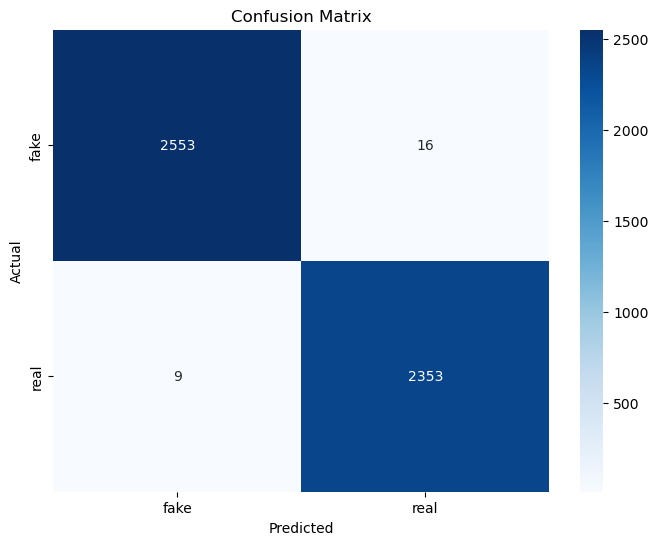

In [65]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [66]:
# Enhanced advisory system
def advisory(label, sentiment, news_text=""):
    # Special cases (like ISRO) should be checked first
    if "ISRO" in news_text.upper() or "Indian Space Research Organisation" in news_text:
        return "Highly credible source - safe to engage"
    
    # Main advisory logic
    advisory_map = {
        ('fake', 'Negative'): "⚠️ Strong likelihood of misinformation with negative sentiment",
        ('fake', 'Neutral'): "⚠️ Potential misinformation - verify with trusted sources",
        ('fake', 'Positive'): "⚠️ Suspicious positive sentiment in fake news - likely manipulative",
        ('real', 'Positive'): "✅ Credible positive news - safe to engage",
        ('real', 'Neutral'): "ℹ️ Factual reporting - verify if controversial",
        ('real', 'Negative'): "⚠️ Credible negative news - important but verify details",
        ('spam', _): "❌ Avoid sharing - likely spam content"
    }
    
    # Get the most specific advice available
    return advisory_map.get((label, sentiment), 
                          advisory_map.get((label, None), 
                                          "⚠️ Review manually - unclear classification"))


In [67]:
# Improved classification function
def classify_news(news_text):
    # Preprocess and predict
    preprocessed_text = vectorizer.transform([news_text])
    predicted_label = clf.predict(preprocessed_text)[0]
    
    # Get detailed sentiment scores
    sentiment_scores = sia.polarity_scores(news_text)
    sentiment = analyze_sentiment(news_text)
    
    # Get advisory
    advice = advisory(predicted_label, sentiment, news_text)
    
    return {
        'text': news_text,
        'prediction': predicted_label,
        'sentiment': sentiment,
        'sentiment_scores': sentiment_scores,
        'advisory': advice
    }

In [68]:
# Test the improved system
test_cases = [
    "The government just announced a new plan to improve healthcare.",
    "Breaking: Stock markets crash as economic crisis deepens",
    "ISRO successfully launches 10 satellites in record mission",
    "Celebrities secretly control the government, insider reveals",
    "New study shows chocolate is actually good for your health"
]

In [69]:
print("\nTesting Improved System:")
print("="*50)
for news in test_cases:
    result = classify_news(news)
    print(f"\nNews: {result['text']}")
    print(f"Predicted: {result['prediction'].upper()}")
    print(f"Sentiment: {result['sentiment']} (Compound: {result['sentiment_scores']['compound']:.2f})")
    print(f"Advisory: {result['advisory']}")
    print("-"*50)


Testing Improved System:

News: The government just announced a new plan to improve healthcare.
Predicted: FAKE
Sentiment: Positive (Compound: 0.44)
Advisory: ⚠️ Suspicious positive sentiment in fake news - likely manipulative
--------------------------------------------------

News: Breaking: Stock markets crash as economic crisis deepens
Predicted: FAKE
Sentiment: Negative (Compound: -0.78)
Advisory: ⚠️ Strong likelihood of misinformation with negative sentiment
--------------------------------------------------

News: ISRO successfully launches 10 satellites in record mission
Predicted: FAKE
Sentiment: Positive (Compound: 0.49)
Advisory: Highly credible source - safe to engage
--------------------------------------------------

News: Celebrities secretly control the government, insider reveals
Predicted: FAKE
Sentiment: Neutral (Compound: 0.00)
Advisory: ⚠️ Potential misinformation - verify with trusted sources
--------------------------------------------------

News: New study sho